# Load from pre-existing model

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pyemma
import warnings
import deeptime as dt
from deeptime.decomposition.deep import VAMPNet
from deeptime.util.exceptions import TrajectoryTooShortError
print(f"PyEMMA {pyemma.__version__}, deeptime {dt.__version__}")

import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.data import DataLoader as PyGDataLoader

from torch.nn import Linear, ReLU, Sequential
from torch_geometric.nn import TransformerConv

import os

from tqdm.notebook import tqdm

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")
torch.set_num_threads(1)

print(f"Using device {device}")

In [ ]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        # GNN layer
        self.conv1 = TransformerConv(-1, 1, heads=2, concat=False, dropouts=0, edge_dim=6)
        
        # MLP layers
        self.mlp = Sequential(
            Linear(280, 64),  # Input from global mean pooling, 280 node features
            ReLU(),
            Linear(64, 16),
            ReLU(),
            Linear(16, 6), # Output layer with 8 nodes
            torch.nn.Softmax()
        )

    def forward(self, batch):
        x, edge_index, edge_attr = batch.x, batch.edge_index, batch.edge_attr

        if x.dim() == 1:
            x = x.unsqueeze(1)

        # Graph convolution
        x = self.conv1(x, edge_index, edge_attr)

        x = x.view(-1, 280)  # Reshape to (num_graphs, 280)
        
        # Process the reshaped features through an MLP
        x = self.mlp(x)
        return x

In [ ]:
model = torch.load('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4.pt',map_location='cpu')
net = model._lobe
net = net.to(device='cpu')

In [5]:
x1 = torch.load('graphs_2/2graphs_500ns.pt')#, map_location=device)
x2 = torch.load('graphs_2/2graphs_100ns.pt')#, map_location=device)
x3 = torch.load('graphs_2/2graphs_50ns.pt')#, map_location=device)
x4 = torch.load('graphs_2/2graphs_500ns_2.pt')#, map_location=device)

x = x1+x2+x3+x4

del x1, x2, x3, x4

In [13]:
out = []
for traj in x:
    for frame in traj:
        out.append(net(frame).cpu().detach().numpy())
del x

/home/chemical/phd/chz198152/.conda/envs/py310/lib/python3.10/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
vnet_cat = np.concatenate(out)
np.save('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_vnet_cat.npy',vnet_cat)

In [15]:
assignments = np.array([np.argmax(i.mean(axis=0)) for i in out])
np.save('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_assignments.npy',assignments)

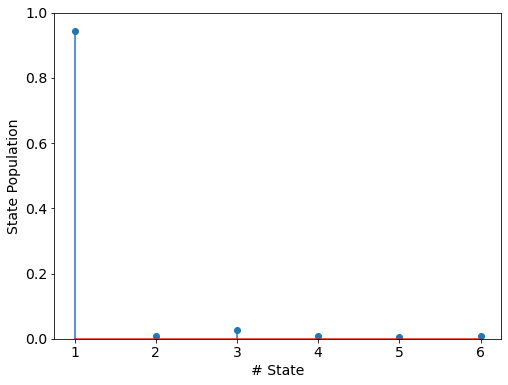

In [18]:
plt.rcParams['font.size']='14'
plt.figure(figsize=(8,6))
_, x = np.unique(assignments,return_counts = True)
x = x/np.sum(x)
plt.stem(x)
plt.xlabel('# State')
plt.ylabel('State Population')
#plt.title('Graph VAMPNet state assignments')
plt.xticks(range(0,6), [str(i) for i in range(1,7)]);
plt.ylim([0,1])
plt.savefig('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_assignments.png', dpi=300, facecolor='white', bbox_inches='tight')

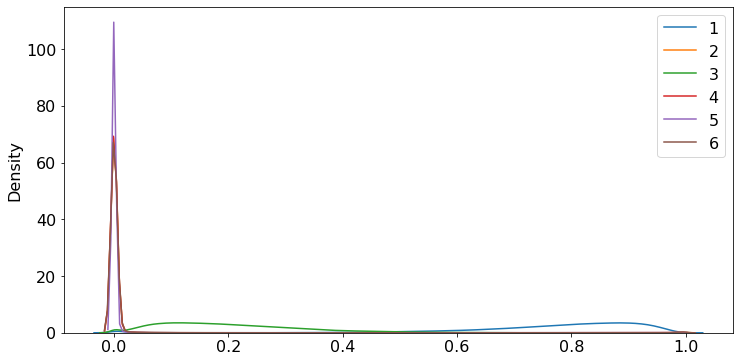

In [49]:
plt.figure(figsize=(12,6))
sns.kdeplot(vnet_cat[:,0])
sns.kdeplot(vnet_cat[:,1])
sns.kdeplot(vnet_cat[:,2])
sns.kdeplot(vnet_cat[:,3])
sns.kdeplot(vnet_cat[:,4])
sns.kdeplot(vnet_cat[:,5])
plt.legend([str(i) for i in range(1,7)])
plt.savefig('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_state1_statedist.png', dpi=300, facecolor='white', bbox_inches='tight')

In [19]:
from deeptime.markov.msm import MaximumLikelihoodMSM
from deeptime.decomposition import VAMP
from deeptime.util.validation import implied_timescales, ck_test
from deeptime.plots import plot_implied_timescales, plot_ck_test

In [20]:
msms = [MaximumLikelihoodMSM(lagtime=lag).fit_fetch(assignments) for lag in tqdm([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])]

  0%|          | 0/10 [00:00<?, ?it/s]

<Figure size 576x288 with 0 Axes>

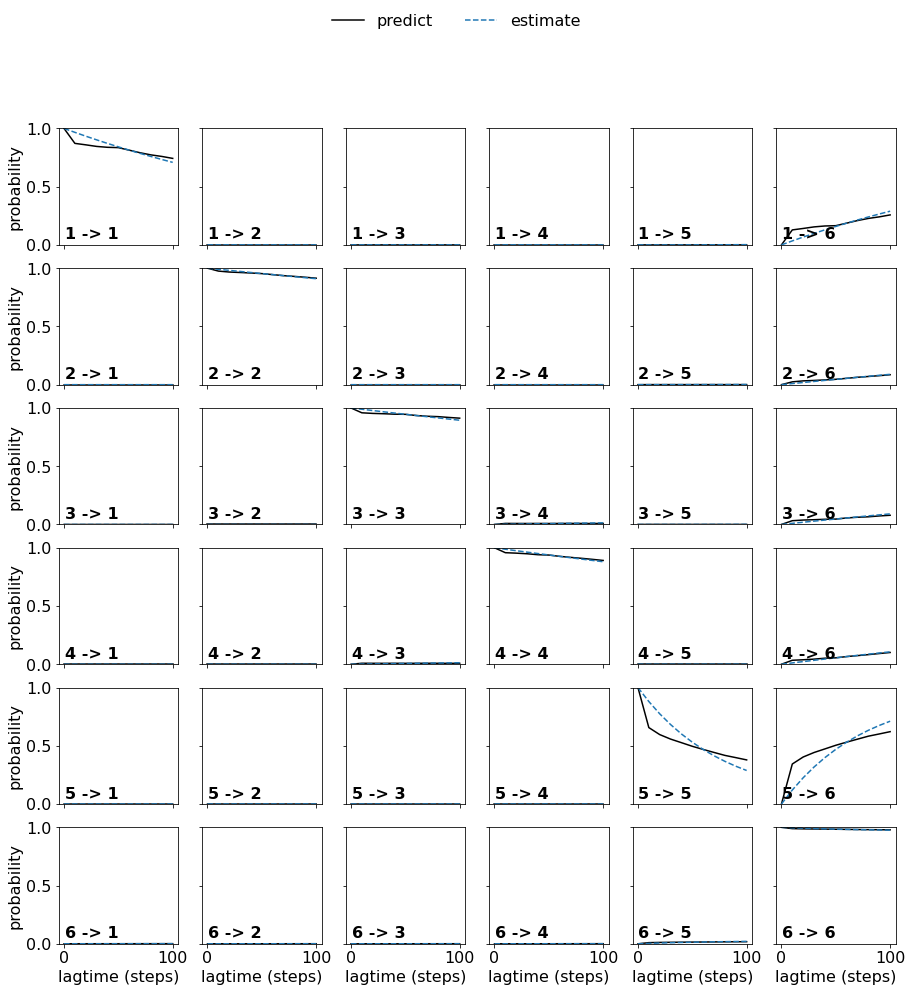

In [26]:
plt.rcParams['font.size']='16'
plt.figure(figsize=(8,4))
ck_test = msms[5].ck_test(msms, 6)
plot_ck_test(ck_test);
msm = msms[5]
plt.savefig('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_msm_cktest.png', dpi=300, bbox_inches='tight', facecolor='white')

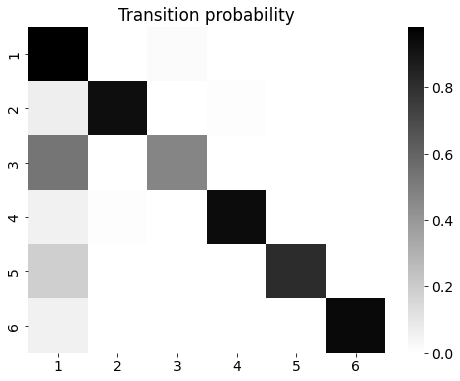

In [28]:
plt.figure(figsize=(8,6))
plt.rcParams['font.size']='14'
import matplotlib as mpl
sns.heatmap(msm.transition_matrix, cmap='gray_r')
plt.title('Transition probability')
plt.xticks(0.5+np.arange(0,6), [str(i) for i in range(1,7)]);
plt.yticks(0.5+np.arange(0,6), [str(i) for i in range(1,7)]);

plt.savefig('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_transition_prob.png', dpi=300, facecolor='white', bbox_inches='tight')

In [29]:
nstates = 6
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        #mfpt[i, j] = msm.mfpt(pcca.sets[i],pcca.sets[j])
        mfpt[i, j] = msm.mfpt(i,j)

from pandas import DataFrame
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

,1,2,3,4,5,6
1,0.00,94528.60,4013.09,114077.39,78452.80,137329.45
2,926.95,0.00,4937.89,102373.79,79379.75,138256.37
3,113.50,94639.95,0.00,114171.28,78559.60,137389.90
4,1050.58,82948.64,5044.07,0.00,79503.35,138379.78
5,321.16,94849.75,4327.54,114398.52,0.00,137650.53
6,1088.32,95616.89,5048.35,115165.45,79541.03,0.00


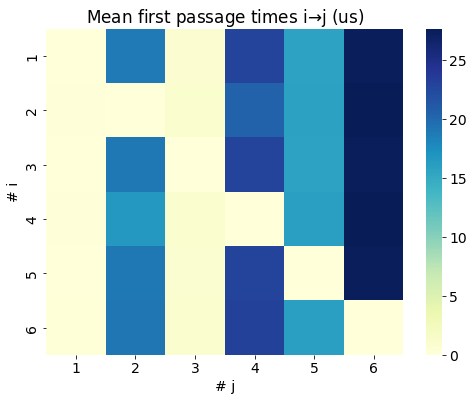

In [30]:
plt.figure(figsize=(8,6))
sns.heatmap((mfpt*0.2/1000), cmap='YlGnBu')
plt.title(r'Mean first passage times i$\to$j (us)')
plt.xticks(0.5+np.arange(0,6), [str(i) for i in range(1,7)]);
plt.yticks(0.5+np.arange(0,6), [str(i) for i in range(1,7)]);
plt.xlabel('# j')
plt.ylabel('# i')
plt.savefig('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_MFPT.png', dpi=300, facecolor='white', bbox_inches='tight')

## CA contacts

In [34]:
x1 = np.load('data/cadist_50ns.npy',allow_pickle=True)
x2 = np.load('data/cadist_100ns.npy',allow_pickle=True)
x3 = np.load('data/cadist_500ns.npy',allow_pickle=True)
x4 = np.load('data/cadist_500ns_2.npy',allow_pickle=True)

x1_1d = np.empty(x1.shape[0], dtype=object)
for i in range(x1.shape[0]):
    x1_1d[i] = x1[i]

ca_data = np.concatenate([x1_1d,x2,x3,x4])
del x1,x2,x3,x4,x1_1d

In [35]:
def convert_to_binary(x):
    binary = []
    for i in x:
        binary.append((i<0.6).astype(np.float16))
    return binary
ca_data = convert_to_binary(ca_data)
ca_data = np.concatenate(ca_data)

In [36]:
def avg_contactmap(cadata,assignments):
    var = assignments.reshape(-1,1).astype(np.float16)
    t = (var*cadata).sum(axis=0)
    t = t/var.sum(dtype=np.float32)
    image = np.zeros([280,280])
    l_ind = np.tril_indices(280,-3)
    image[l_ind] = t
    image = image + image.T
    return image

In [50]:
camap = avg_contactmap(ca_data,vnet_cat[:,0])
np.save('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_camap_state1.npy', camap)

In [51]:
camap = avg_contactmap(ca_data,vnet_cat[:,1])
np.save('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_camap_state2.npy', camap)

In [52]:
camap = avg_contactmap(ca_data,vnet_cat[:,2])
np.save('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_camap_state3.npy', camap)

In [53]:
camap = avg_contactmap(ca_data,vnet_cat[:,3])
np.save('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_camap_state4.npy', camap)

In [54]:
camap = avg_contactmap(ca_data,vnet_cat[:,4])
np.save('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_camap_state5.npy', camap)

In [55]:
camap = avg_contactmap(ca_data,vnet_cat[:,5])
np.save('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_camap_state6.npy', camap)

0.003304447280243039


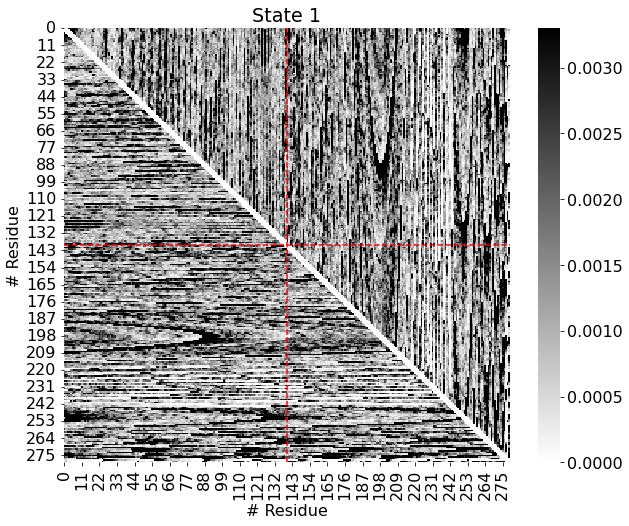

In [108]:
plt.rcParams['font.size'] = '16'
plt.figure(figsize=(10,8))
image = np.load('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_camap_state1.npy')
print(image.max())
sns.heatmap(image,cmap='gist_yarg')
norm = image/image.max()
#plt.scatter(*np.where(norm>0.5),c='k')
plt.xlabel('# Residue')
plt.ylabel('# Residue')
plt.axhline(140,linestyle='--',c='r')
plt.axvline(140,linestyle='--',c='r')
#plt.text(-50,270,'State 1')
plt.title('State 1')
#plt.xlim([-5,290])
#plt.ylim([-5,290])
plt.savefig('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_state1_camap.png',dpi=600,bbox_inches='tight',facecolor='white')

# Analysis from a MSM

In [24]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pyemma
import warnings
import deeptime as dt
from deeptime.decomposition.deep import VAMPNet
from deeptime.util.exceptions import TrajectoryTooShortError
print(f"PyEMMA {pyemma.__version__}, deeptime {dt.__version__}")

import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.data import DataLoader as PyGDataLoader

from torch.nn import Linear, ReLU, Sequential
from torch_geometric.nn import TransformerConv

import os

from tqdm.notebook import tqdm

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")
torch.set_num_threads(1)

print(f"Using device {device}")
from deeptime.markov.msm import MaximumLikelihoodMSM
from deeptime.decomposition import VAMP
from deeptime.util.validation import implied_timescales, ck_test
from deeptime.plots import plot_implied_timescales, plot_ck_test

PyEMMA 2.5.12, deeptime 0.4.4
Using device cpu


In [25]:
assignments = np.load('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_assignments.npy')

In [26]:
msms = [MaximumLikelihoodMSM(lagtime=lag).fit_fetch(assignments) for lag in tqdm([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])]
msm = msms[5]

  0%|          | 0/10 [00:00<?, ?it/s]

In [27]:
msm.timescales()

array([1049.52476846,  956.27898579,  729.74194014,  288.59836113,
         75.77079708])

## Eigenvalues

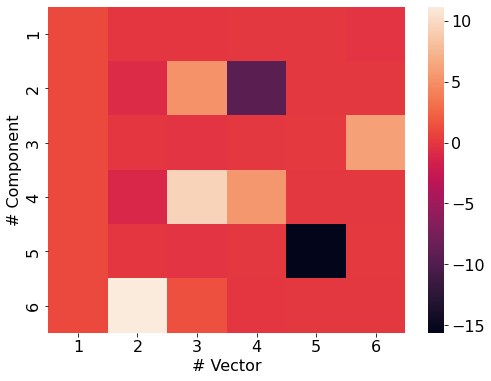

In [28]:
plt.rcParams['font.size'] = '16'
plt.figure(figsize=(8,6))
sns.heatmap(msm.eigenvectors_right())
plt.xticks(0.5+np.arange(0,6), [str(i) for i in range(1,7)]);
plt.yticks(0.5+np.arange(0,6), [str(i) for i in range(1,7)]);
plt.ylabel('# Component')
plt.xlabel('# Vector')
plt.savefig('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_msm_rightevec.png',dpi=600,bbox_inches='tight',facecolor='white')

In [30]:
np.save('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_msm_rightevec.npy',msm.eigenvectors_right())

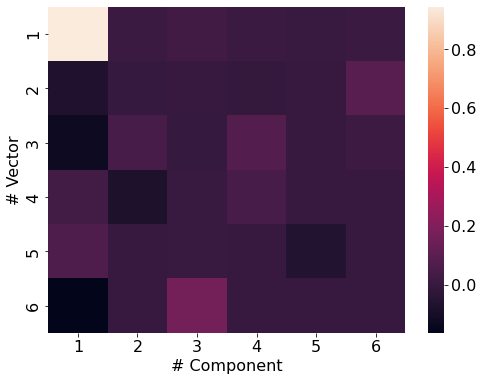

In [31]:
plt.rcParams['font.size'] = '16'
plt.figure(figsize=(8,6))
sns.heatmap(msm.eigenvectors_left())
plt.xticks(0.5+np.arange(0,6), [str(i) for i in range(1,7)]);
plt.yticks(0.5+np.arange(0,6), [str(i) for i in range(1,7)]);
plt.xlabel('# Component')
plt.ylabel('# Vector')
plt.savefig('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_msm_leftevec.png',dpi=600,bbox_inches='tight',facecolor='white')

In [32]:
np.save('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_msm_leftevec.npy',msm.eigenvectors_left())

## Committor

In [33]:
from deeptime.markov.tools.analysis import committor

In [34]:
committor(msm.transition_matrix,[0],[1,2,3,4,5],forward=False)

array([1., 0., 0., 0., 0., 0.])

## Flux matrix

In [4]:
from deeptime.markov.tools.flux import flux_matrix

In [ ]:
flux_matrix(msm.transition_matrix)

## Reactive fluxes

In [ ]:
from deeptime.markov import reactive_flux

In [18]:
reactive_flux(msm.transition_matrix,[0],[1]).stationary_distribution

array([0.94391609, 0.00862858, 0.02735459, 0.00817405, 0.00407464,
       0.00785204])

In [40]:
pa = reactive_flux(msm.transition_matrix,range(1,6),[0]).pathways

In [58]:
from deeptime.markov.tools.analysis import timescales
timescales(msm.transition_matrix)

array([        inf, 17.49207947, 15.9379831 , 12.16236567,  4.80997269,
        1.26284662])

In [35]:
from deeptime.markov import reactive_flux

In [36]:
r_flux = reactive_flux(msm.transition_matrix,[0],range(1,6))

Text(46.0, 0.5, '# i')

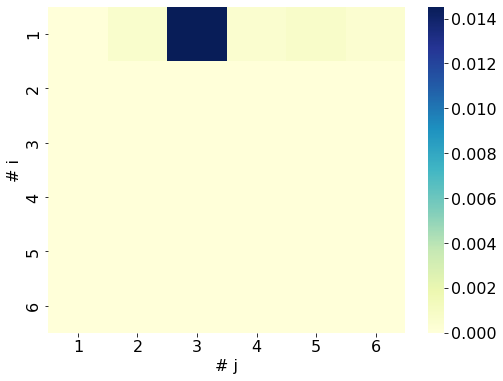

In [8]:
plt.rcParams['font.size'] = '16'
plt.figure(figsize=(8,6))
sns.heatmap(r_flux.gross_flux, cmap='YlGnBu')
plt.xticks(0.5+np.arange(0,6), [str(i) for i in range(1,7)]);
plt.yticks(0.5+np.arange(0,6), [str(i) for i in range(1,7)]);
plt.xlabel('# j')
plt.ylabel('# i')
#plt.savefig('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_.png', dpi=300, facecolor='white', bbox_inches='tight')

In [37]:
stationary_distribution = reactive_flux(msm.transition_matrix,[0],[1]).stationary_distribution

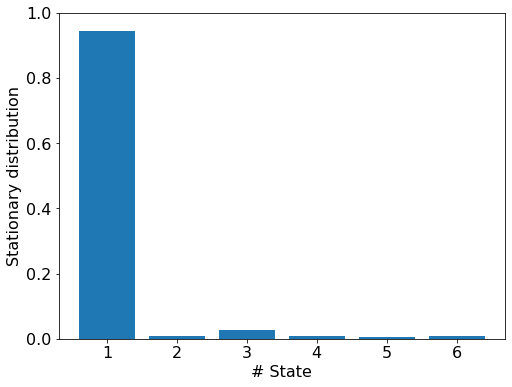

In [38]:
plt.rcParams['font.size'] = '16'
plt.figure(figsize=(8,6))
plt.bar(np.arange(1,7),stationary_distribution)
plt.ylim([0,1])
plt.ylabel('Stationary distribution')
plt.xlabel('# State')
plt.savefig('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_msm_stationarydist.png',dpi=600,bbox_inches='tight',facecolor='white')
np.save('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_msm_stationarydist.npy',stationary_distribution)

In [54]:
major_pathways = reactive_flux(msm.transition_matrix,[0],range(1,6)).pathways()
major_pathways

([array([0, 2], dtype=int32),
  array([0, 4], dtype=int32),
  array([0, 1], dtype=int32),
  array([0, 3], dtype=int32),
  array([0, 5], dtype=int32)],
 [0.01453061740107241,
  0.0007604346119120783,
  0.0005678489732275048,
  0.0004563846164325748,
  0.00042789928080720375])

In [56]:
major_flux = reactive_flux(msm.transition_matrix,[0],range(1,6)).major_flux()
major_flux

array([[0.        , 0.        , 0.01453062, 0.        , 0.00076043,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

## Plot adjacency

In [6]:
from deeptime.plots import plot_adjacency

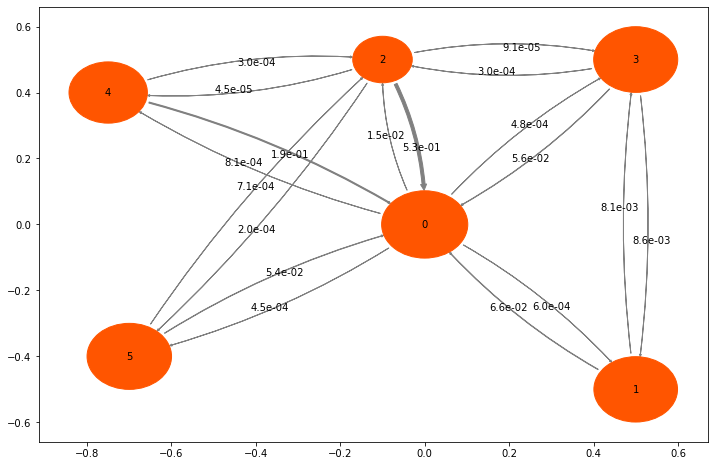

In [7]:
plt.rcParams['font.size'] = '12'
plt.figure(figsize=(12,8))
pos = np.array([[0,0],[0.5,-0.5],[-0.1,0.5],[0.5,0.5],[-0.75,0.4],[-0.7,-0.4]])
plot_adjacency(msm.transition_matrix,pos)
plt.savefig('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_msm_adjacency.png',dpi=600,bbox_inches='tight',facecolor='white')

## Plot network

In [4]:
from deeptime.plots import Network
#import networkx as nx

<AxesSubplot:>

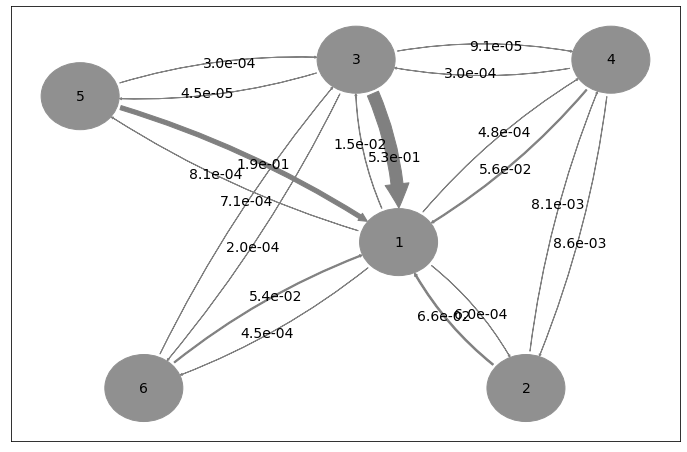

In [27]:
plt.rcParams['font.size'] = '14'
plt.figure(figsize=(12,8))
plt.xticks([])
plt.yticks([])
pos = np.array([[0,0],[0.3,-0.4],[-0.1,0.5],[0.5,0.5],[-0.75,0.4],[-0.6,-0.4]])
mod_state_size = stationary_distribution
#mod_state_size[0] = mod_state_size[0]
Network(msm.transition_matrix,pos,state_colors='#909090', state_labels=range(1,7),edge_scale=4).plot()
#plt.savefig('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_msm_network3.png',dpi=600,bbox_inches='tight',facecolor='white')

## Plot markov model

In [4]:
from deeptime.plots import plot_markov_model

In [34]:
nstates = 6
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        #mfpt[i, j] = msm.mfpt(pcca.sets[i],pcca.sets[j])
        mfpt[i, j] = msm.mfpt(i,j)

from pandas import DataFrame
rates = np.array(DataFrame(np.round(1/(mfpt*0.2/1000), decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1)))

/var/tmp/pbs.221666.pbshpc/ipykernel_32409/4118842407.py:9: RuntimeWarning: divide by zero encountered in divide
  rates = np.array(DataFrame(np.round(1/(mfpt*0.2/1000), decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1)))


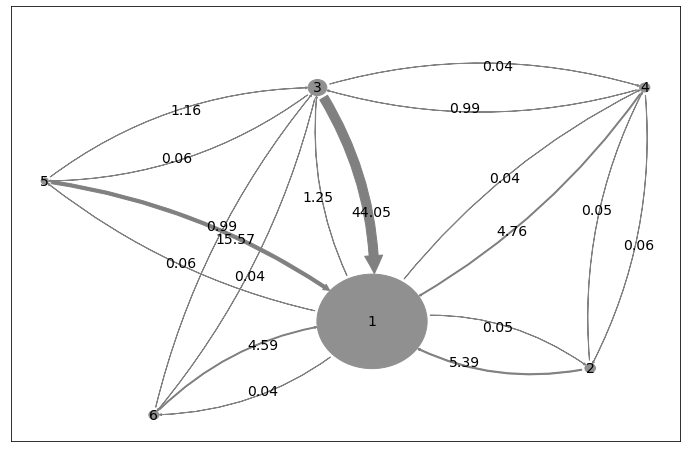

In [62]:
plt.rcParams['font.size'] = '14'
plt.figure(figsize=(12,8))
plt.xticks([])
plt.yticks([])
pos = np.array([[0,0],[0.4,-0.1],[-0.1,0.5],[0.5,0.5],[-0.6,0.3],[-0.4,-0.2]])
#mod_state_size = stationary_distribution
#mod_state_size[0] = mod_state_size[0]
a = plot_markov_model(msm,pos=pos,state_scale=2.0,state_colors='#909090', state_labels=range(1,7),edge_scale=3, edge_curvature=1.2, edge_labels=rates, edge_label_format='{:.2f}')
plt.savefig('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_msm_plot.png',dpi=600,bbox_inches='tight',facecolor='white')

## Plot Rgs

In [39]:
rg = np.loadtxt('rg.txt')[:,1]

In [40]:
vnet_cat = np.load('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_vnet_cat.npy')
rg_weighted = (vnet_cat*rg.reshape(-1,1)).sum(axis=0)
vnet_cat_sum = vnet_cat.sum(axis=0)
rg_state = rg_weighted/vnet_cat_sum

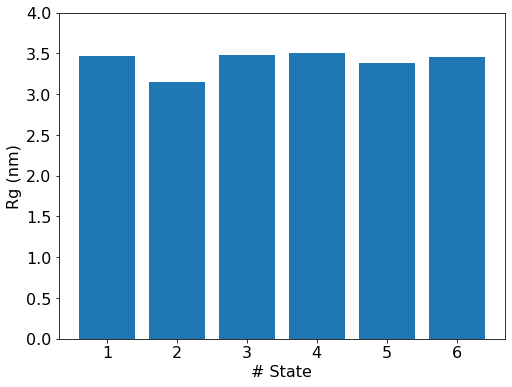

In [41]:
plt.rcParams['font.size'] = '16'
plt.figure(figsize=(8,6))
plt.bar(np.arange(1,7),rg_state)
plt.xlabel('# State')
plt.ylabel('Rg (nm)')
plt.xticks(range(1,7), [str(i) for i in range(1,7)]);
plt.ylim([0,4])
plt.savefig('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_state1_rg_state.png',dpi=600,bbox_inches='tight',facecolor='white')

In [47]:
np.save('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_state1_rg_state.npy',rg_state)

## Plot average beta content

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
beta = np.loadtxt('beta_content.txt')

In [50]:
vnet_cat = np.load('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_vnet_cat.npy')
beta_weighted = (vnet_cat*beta.reshape(-1,1)).sum(axis=0)
vnet_cat_sum = vnet_cat.sum(axis=0)
beta_state = beta_weighted/vnet_cat_sum

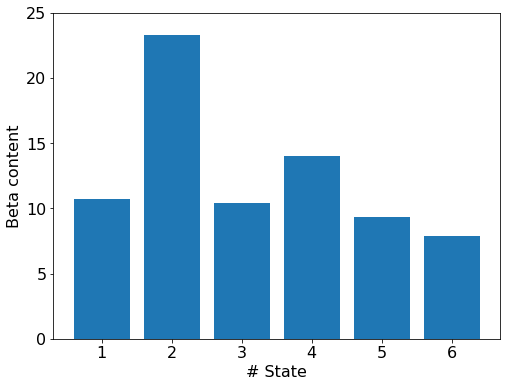

In [51]:
plt.rcParams['font.size'] = '16'
plt.figure(figsize=(8,6))
plt.bar(np.arange(1,7),beta_state)
plt.xlabel('# State')
plt.ylabel('Beta content')
plt.xticks(range(1,7), [str(i) for i in range(1,7)]);
plt.ylim([0,25])
plt.savefig('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_state1_betacontent_state.png',dpi=600,bbox_inches='tight',facecolor='white')

In [52]:
np.save('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_state1_betacontent_state.png',beta_state)

## Plot average interchain contacts

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
beta = np.loadtxt('inter_mainchain_contacts.txt')[:,1]

In [55]:
vnet_cat = np.load('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_vnet_cat.npy')
beta_weighted = (vnet_cat*beta.reshape(-1,1)).sum(axis=0)
vnet_cat_sum = vnet_cat.sum(axis=0)
beta_state = beta_weighted/vnet_cat_sum

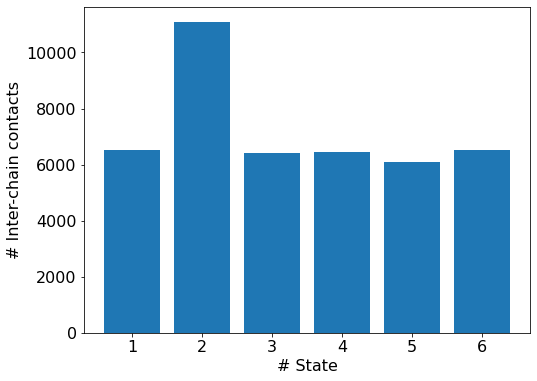

In [56]:
plt.rcParams['font.size'] = '16'
plt.figure(figsize=(8,6))
plt.bar(np.arange(1,7),beta_state)
plt.xlabel('# State')
plt.ylabel('# Inter-chain contacts')
plt.xticks(range(1,7), [str(i) for i in range(1,7)]);
#plt.ylim([0,25])
plt.savefig('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_state1_interchaincontacts_state.png',dpi=600,bbox_inches='tight',facecolor='white')

In [58]:
np.save('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_state1_interchaincontacts_state.png',beta_state)

## Plot average interchain main chain H bonds

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
beta = np.loadtxt('inter_mainchain_hbonds.txt')[:,1]

In [61]:
vnet_cat = np.load('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_vnet_cat.npy')
beta_weighted = (vnet_cat*beta.reshape(-1,1)).sum(axis=0)
vnet_cat_sum = vnet_cat.sum(axis=0)
beta_state = beta_weighted/vnet_cat_sum

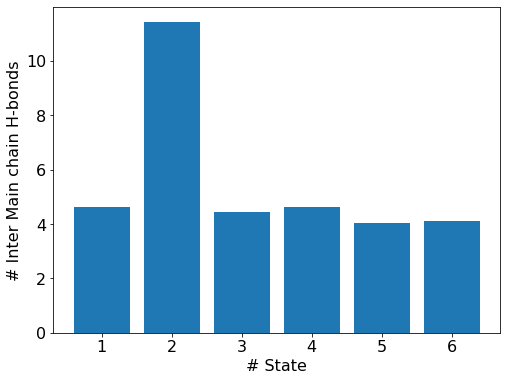

In [62]:
plt.rcParams['font.size'] = '16'
plt.figure(figsize=(8,6))
plt.bar(np.arange(1,7),beta_state)
plt.xlabel('# State')
plt.ylabel('# Inter Main chain H-bonds')
plt.xticks(range(1,7), [str(i) for i in range(1,7)]);
#plt.ylim([0,25])
plt.savefig('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_state1_intermainchainHbonds_state.png',dpi=600,bbox_inches='tight',facecolor='white')

In [63]:
np.save('graph_2_outputs/transformerconv_t50_n6_e1000_b256_c1_d2_r4_state1_intermainchainHbonds_state.png',beta_state)

## Re plot

In [17]:
from deeptime.markov.msm import MaximumLikelihoodMSM
from deeptime.decomposition import VAMP
from deeptime.util.validation import implied_timescales, ck_test
from deeptime.plots import plot_implied_timescales, plot_ck_test

In [19]:
lagtimes = np.arange(10, 110, 10)
vamp_models = [VAMP(lagtime=lag, observable_transform=model).fit_fetch(data) for lag in tqdm(lagtimes)]

  0%|          | 0/10 [00:00<?, ?it/s]

/home/chemical/phd/chz198152/.conda/envs/py310/lib/python3.10/site-packages/deeptime/util/data.py:424: UserWarning: Skipping trajectory 1253: Not enough data (length=40) to satisfy lagtime=40.
  warnings.warn(f"Skipping trajectory {i}: {e}", UserWarning)
/home/chemical/phd/chz198152/.conda/envs/py310/lib/python3.10/site-packages/deeptime/util/data.py:424: UserWarning: Skipping trajectory 1253: Not enough data (length=40) to satisfy lagtime=50.
  warnings.warn(f"Skipping trajectory {i}: {e}", UserWarning)
/home/chemical/phd/chz198152/.conda/envs/py310/lib/python3.10/site-packages/deeptime/util/data.py:424: UserWarning: Skipping trajectory 1253: Not enough data (length=40) to satisfy lagtime=60.
  warnings.warn(f"Skipping trajectory {i}: {e}", UserWarning)
/home/chemical/phd/chz198152/.conda/envs/py310/lib/python3.10/site-packages/deeptime/util/data.py:424: UserWarning: Skipping trajectory 1253: Not enough data (length=40) to satisfy lagtime=70.
  warnings.warn(f"Skipping trajectory {i}:

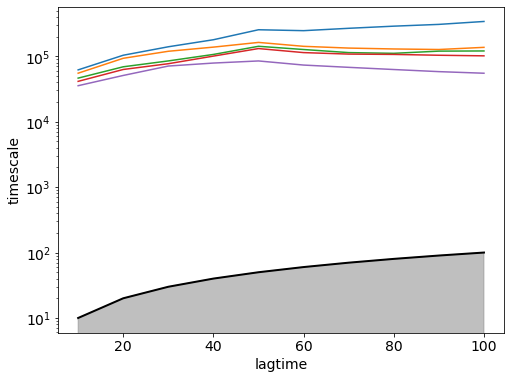

In [24]:
plt.figure(figsize=(8,6))
plt.rcParams['font.size']='14'
ax = plot_implied_timescales(implied_timescales(vamp_models))
ax.set_yscale('log')
ax.set_xlabel('lagtime')
ax.set_ylabel('timescale')
plt.savefig('pca2k_relaxtimescales.png', dpi=300, bbox_inches='tight', facecolor='white')